In [1]:
import networkx as nx
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

In [3]:
plt.rcParams["figure.figsize"] = (20,3)

In [4]:
from shared.constants import DatasetPath
from datasets.schema import DatasetSchema
from datasets.loading import load_igraph, igraph_to_nx

from datasets.visualization import plot_explore_dual_histogram, show_top_k_nodes, show_top_k_stacked_nodes

In [5]:
DATASET = DatasetPath('DBLP-V3')
schema = DatasetSchema.load_schema(DATASET.name)
G = load_igraph(schema, prefix_id=True)

In [6]:
TIMESTAMP_BINS = 50
K = 10
HAS_NODE_TIMESTAMP = schema.is_node_temporal()
HAS_EDGE_TIMESTAMP = schema.is_edge_temporal()
BETWEENESS_K = 1

print('Has node timestamp: {}'.format(HAS_NODE_TIMESTAMP))
print('Has edge timestamp: {}'.format(HAS_EDGE_TIMESTAMP))

Has node timestamp: True
Has edge timestamp: False


# Dataset Specific Statistics

## Visualize Distribution of Nodes over Time

In [7]:
NODE_TIMESTAMPS = pd.Series(G.vs['timestamp'], name='timestamp', index=G.vs['name']) if HAS_NODE_TIMESTAMP else None
EDGE_TIMESTAMPS = pd.Series(G.es['timestamp'], name='timestamp', index=range(G.ecount())) if HAS_EDGE_TIMESTAMP else None
LABELS = pd.Series(G.vs['label'], name='label', index=G.vs['name'])

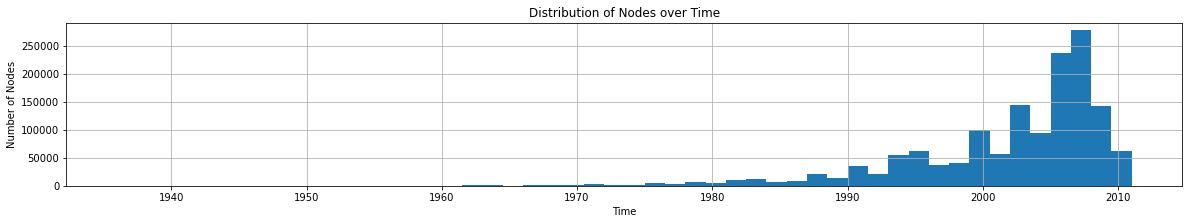

In [8]:
if HAS_NODE_TIMESTAMP:
    NODE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(NODE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Nodes over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Nodes')
else:
    print('No node timestamp data available')

In [9]:
if HAS_EDGE_TIMESTAMP:
    EDGE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(EDGE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Edges over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Edges')
else:
    print('No edge timestamp data available')

No edge timestamp data available


# Global Statistics

In [10]:
print(f'Number of Nodes: {G.vcount()}')
print(f'Number of Edges: {G.ecount()}')
print(f'Density: {G.density()}')

Number of Nodes: 2677140
Number of Edges: 8243751
Density: 2.3004503125662297e-06


In [11]:
degrees = pd.Series(G.degree(), index=G.vs['name'])

In [12]:
print(f'Average Degree: {np.mean(degrees)}')
print(f'Median Degree: {np.median(degrees)}')

Average Degree: 6.158625249333244
Median Degree: 3.0


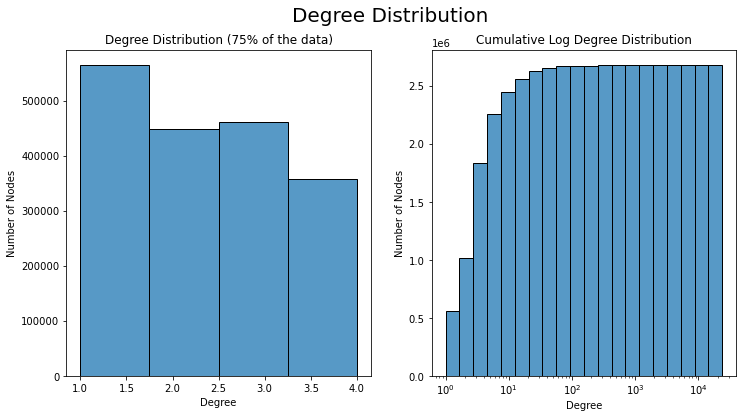

In [13]:
plot_explore_dual_histogram(
    series=degrees,
    title='Degree Distribution',
    title_short='Degree Distribution',
    xlabel='Degree',
    ylabel='Number of Nodes',
    normalize=False,
)
plt.show()

In [14]:
show_top_k_nodes(
    degrees,
    LABELS,
    title='Degree Nodes'
)

Top 10 Degree Nodes


,value,label
0,23730,CoRR
1,18243,
2,10236,ICRA
3,10204,Discrete Mathematics
4,9234,Commun. ACM
5,8403,Theor. Comput. Sci.
6,7889,IEICE Transactions
7,7465,"Microwave Theory and Techniques, IEEE Transact..."
8,7385,IEEE Transactions on Information Theory
9,7092,Electronics Letters


## Connectivity Metrics
* **degree_centrality**: Degree centrality of a node is the fraction of nodes it is connected to.
* **closeness_centrality**: Closeness centrality of a node is the inverse of the average shortest path length to all other nodes.
* **betweenness_centrality**: Betweenness centrality of a node is the fraction of all shortest paths in the network that pass through it.
* **eigenvector_centrality**: Eigenvector centrality of a node is the normalized sum of the eigenvector centralities of all its neighbors.
* **pagerank**: PageRank is a ranking of nodes based on the structure of the network.
* **transitivity**: Clustering coefficient is the fraction of triangles that are formed by a node and its neighbors.

In [15]:
# Use the largest connected component
G_cc = G.clusters().giant()

# Convert to NetworkX
nx_G = igraph_to_nx(G_cc)
nx_Gu = nx.Graph(nx_G)

In [16]:
print('Average Clustering Coefficient: {}'.format(nx.approximation.average_clustering(nx_Gu)))
print('Diameter: {}'.format(nx.approximation.diameter(nx_Gu)))

Average Clustering Coefficient: 0.032
Diameter: 18


In [17]:
# Calculate the metrics
metrics_dict = {}

metrics_dict['degree_centrality'] = nx.degree_centrality(nx_G)
try:
    metrics_dict['betweenness_centrality'] = nx.betweenness_centrality(nx_Gu, k=BETWEENESS_K)
except Exception as e:
    print('Betweenness Centrality Error: {}'.format(e))
try:
    u = 0
    # metrics_dict['eigenvector_centrality'] = nx.eigenvector_centrality(nx_Gu)
except Exception as e:
    print('Eigenvector Centrality Error: {}'.format(e))
metrics_dict['page_rank'] = nx.pagerank(nx_Gu)
metrics_dict['transitivity'] = dict(zip(G_cc.vs['name'], G_cc.transitivity_local_undirected()))

NODE_STATS = pd.DataFrame(metrics_dict)
NODE_STATS.describe()

,degree_centrality,betweenness_centrality,page_rank,transitivity
count,2.676768e+06,2.676768e+06,2.676768e+06,2.112882e+06
mean,2.301013e-06,1.916357e-06,3.735849e-07,2.874701e-02
std,1.413967e-05,5.316247e-04,3.598892e-06,8.514798e-02
min,3.735850e-07,0.000000e+00,5.605514e-08,0.000000e+00
25%,7.471700e-07,0.000000e+00,1.178712e-07,0.000000e+00
50%,1.120755e-06,0.000000e+00,1.830566e-07,0.000000e+00
75%,1.867925e-06,2.988682e-07,3.751647e-07,0.000000e+00
max,8.865172e-03,8.268143e-01,3.009207e-03,1.000000e+00


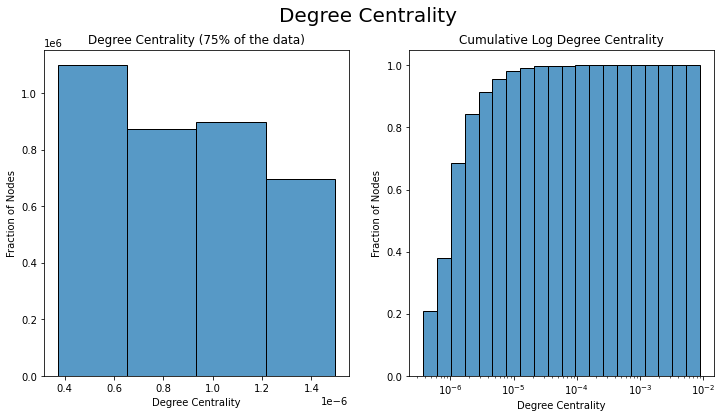

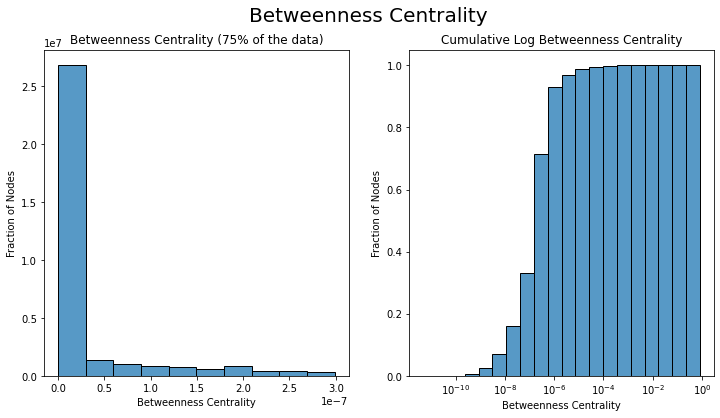

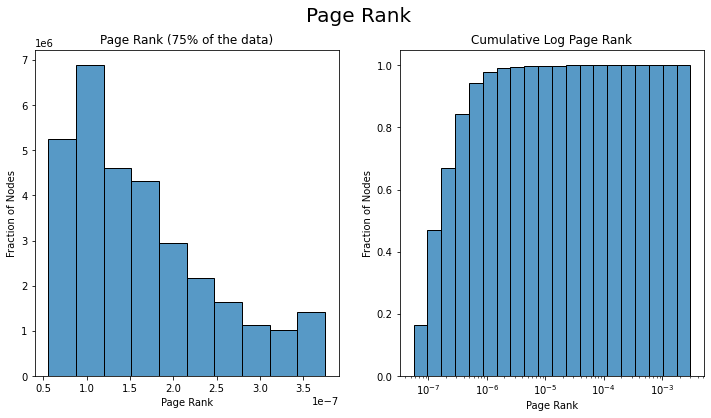

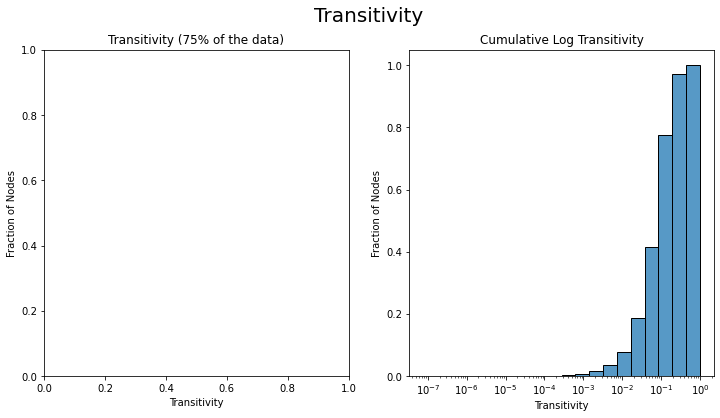

In [18]:
for col in NODE_STATS.columns:
    title = col.replace('_', ' ').title()
    data = NODE_STATS[col][np.isfinite(NODE_STATS[col])]
    try:
        plot_explore_dual_histogram(
            series=data,
            title=title,
            title_short=title,
            xlabel=title,
            ylabel='Fraction of Nodes',
            normalize=True,
        )
        plt.show()
    except:
        print(f'Failed to plot {title}')

In [19]:
show_top_k_stacked_nodes(
    NODE_STATS,
    LABELS,
    title='Nodes by Statistic',
)

Top 10 Nodes by Statistic


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.008865,CoRR,0.826814,ISBI,0.003009,,1.0,Andrew A. Lamb
1,0.006815,,0.218684,,0.002309,CoRR,1.0,Amit Dhawan
2,0.003824,ICRA,0.092124,Klaus Mueller,0.001139,Discrete Mathematics,1.0,Nima Tajbakhsh
3,0.003812,Discrete Mathematics,0.053957,Lawrence H. Staib,0.000868,"Microwave Theory and Techniques, IEEE Transact...",1.0,Carven Chan
4,0.003450,Commun. ACM,0.036447,Proceedings of the 2002 IEEE International Sym...,0.000852,ICRA,1.0,James M. Sagawa
5,0.003139,Theor. Comput. Sci.,0.036447,Proceedings of the 2008 IEEE International Sym...,0.000788,Commun. ACM,1.0,Leonid Mitjushin
6,0.002947,IEICE Transactions,0.036447,Proceedings of the 2007 IEEE International Sym...,0.000761,IEEE Transactions on Information Theory,1.0,Olli Malve
7,0.002789,"Microwave Theory and Techniques, IEEE Transact...",0.036447,Proceedings of the 2009 IEEE International Sym...,0.000722,"Antennas and Propagation, IEEE Transactions on",1.0,Ilya Lashuk
8,0.002759,IEEE Transactions on Information Theory,0.036447,Proceedings of the 2006 IEEE International Sym...,0.000708,"Automatic Control, IEEE Transactions on",1.0,Harper Langston
9,0.002649,Electronics Letters,0.036447,Proceedings of the 2004 IEEE International Sym...,0.000663,Applied Mathematics and Computation,1.0,Thomas R. Amoth


## Connected Components Statistics

In [20]:
print(f'Number of Connected Components: {len(G.components())}')
largest_cc = G.components().giant()
print(f'Size of the largest component: {largest_cc.vcount()}')

Number of Connected Components: 99
Size of the largest component: 2676768


Text(0.5, 1.0, 'Connected Components')

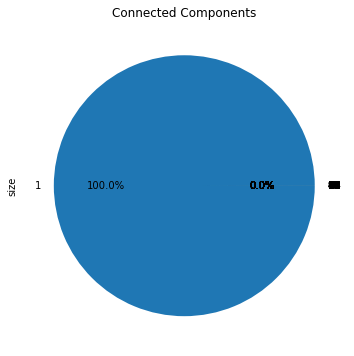

In [21]:
df_tmp = pd.Series(list(map(len, G.components())), name='size', index=range(1,len(G.components())+1))
ax = df_tmp.sort_values(ascending=False).head(30).plot.pie(
    y='size',
    figsize=(6,6),
    autopct='%1.1f%%',
    legend=False,
)
ax.set_title('Connected Components')

# Type Specific Statistics

### Node Type Statistics

In [22]:
node_types = schema.get_node_types()
node_type_stats = pd.DataFrame([
    {
        'type': node_type,
        'count': len(G.vs.select(type=node_type)),
        'degree_avg': np.mean(G.vs.select(type=node_type).degree()),
        'degree_median': np.median(G.vs.select(type=node_type).degree()),
    }
    for node_type in node_types
], index=node_types)
print('Node Type count: {}'.format(len(node_types)))
node_type_stats

Node Type count: 3


,type,count,degree_avg,degree_median
Author,Author,1036991,4.132676,1.0
Venue,Venue,7707,211.593746,48.0
Paper,Paper,1632442,6.475698,4.0


<AxesSubplot:title={'center':'Node type counts'}, ylabel='count'>

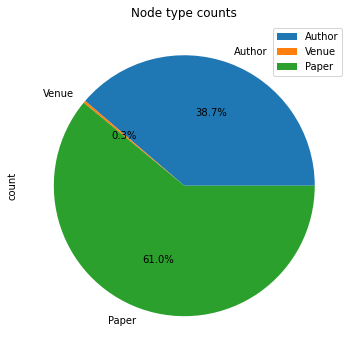

In [23]:
node_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Node type counts', figsize=(6,6))

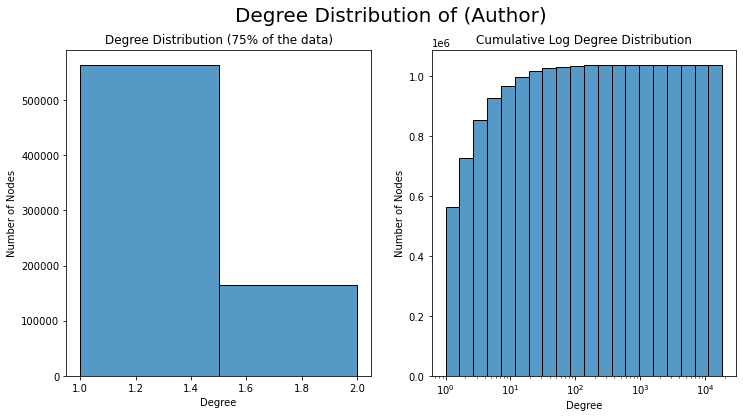

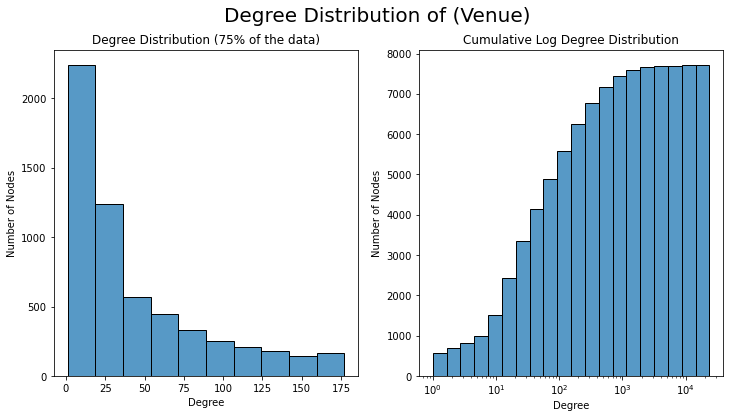

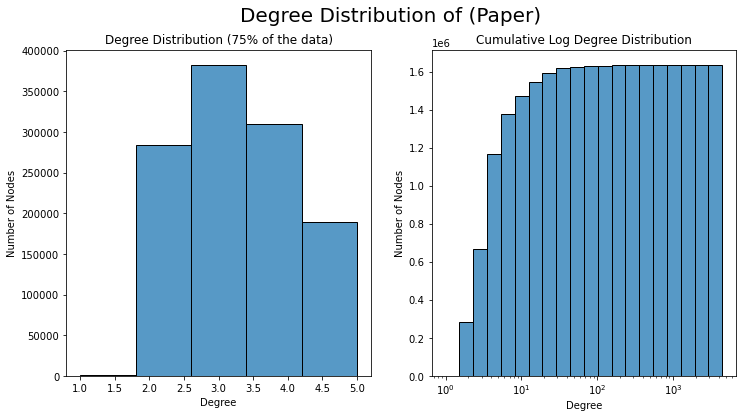

In [24]:
for node_type in node_types:
    degrees = pd.Series(G.vs.select(type=node_type).degree())
    plot_explore_dual_histogram(
        series=degrees,
        title=f'Degree Distribution of ({node_type})',
        title_short='Degree Distribution',
        xlabel='Degree',
        ylabel='Number of Nodes',
    )
    plt.show()

In [25]:
for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    data = pd.Series(nodes.degree(), index=nodes['name'])
    show_top_k_nodes(
        data,
        LABELS,
        title=f'Degree Nodes of Type ({node_type})'
    )

Top 10 Degree Nodes of Type (Author)


,value,label
0,18243,
1,1986,Jr.
2,588,Philip S. Yu
3,567,Chin-Chen Chang
4,554,Elisa Bertino
5,534,Thomas S. Huang
6,501,Wen Gao
7,487,Wei Wang
8,484,Edwin R. Hancock
9,481,Ming Li


Top 10 Degree Nodes of Type (Venue)


,value,label
0,23730,CoRR
1,10236,ICRA
2,10204,Discrete Mathematics
3,9234,Commun. ACM
4,8403,Theor. Comput. Sci.
5,7889,IEICE Transactions
6,7465,"Microwave Theory and Techniques, IEEE Transact..."
7,7385,IEEE Transactions on Information Theory
8,7092,Electronics Letters
9,6346,HICSS


Top 10 Degree Nodes of Type (Paper)


,value,label
0,4476,Computers and Intractability: A Guide to the T...
1,2376,C4.5: Programs for Machine Learning
2,2295,Introduction to Algorithms
3,1578,Communicating Sequential Processes
4,1558,"Compilers: Princiles, Techniques, and Tools."
5,1451,Mining Association Rules between Sets of Items...
6,1433,Fast Algorithms for Mining Association Rules i...
7,1355,Introduction to Modern Information Retrieval.
8,1258,Graph-Based Algorithms for Boolean Function Ma...
9,1200,Concurrency Control and Recovery in Database S...


### Edge Type Statistics

In [26]:
edge_types = schema.get_edge_types()
edge_type_stats = pd.DataFrame([
    {
        'type': edge_type,
        'count': len(G.es.select(type=edge_type)),
    }
    for edge_type in edge_types
], index=edge_types)
print('Edge Type count: {}'.format(len(edge_types)))
edge_type_stats

Edge Type count: 3


,type,count
AUTHORED,AUTHORED,4285548
PUBLISHED_IN,PUBLISHED_IN,1630753
CITED,CITED,2327450


<AxesSubplot:title={'center':'Edge type counts'}, ylabel='count'>

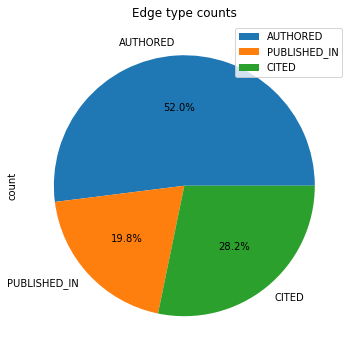

In [27]:
edge_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Edge type counts', figsize=(6,6))

## Node Type Connectivity Statistics

In [28]:
node_stats_by_type = {}

for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    names = set(nodes['name']) & set(NODE_STATS.index)

    node_stats_by_type[node_type] = NODE_STATS.loc[names]

In [29]:
for node_type in node_types:
    show_top_k_stacked_nodes(
        node_stats_by_type[node_type],
        LABELS,
        title=f'Nodes by Statistic for {node_type}',
    )

Top 10 Nodes by Statistic for Author


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.006815,,0.218684,,0.003009,,1.0,Leith Abdulla
1,0.000742,Jr.,0.092124,Klaus Mueller,0.000111,Jr.,1.0,Erik Wistrand
2,0.000220,Philip S. Yu,0.053957,Lawrence H. Staib,0.000041,Chin-Chen Chang,1.0,Jenna Hayes
3,0.000212,Chin-Chen Chang,0.024561,Marcel Jackowski,0.000039,Diane Crawford,1.0,Daniel Dumitran
4,0.000207,Elisa Bertino,0.015893,Wei Wang,0.000039,Grzegorz Rozenberg,1.0,Antal Novak
5,0.000199,Thomas S. Huang,0.007214,Bo Zhang,0.000038,Edwin R. Hancock,1.0,Trevor M. Craig
6,0.000187,Wen Gao,0.006660,Li Zhang,0.000034,Thomas S. Huang,1.0,Ken Furudate
7,0.000182,Wei Wang,0.006154,Lei Guo,0.000033,Robert L. Glass,1.0,Marya Lieberman
8,0.000181,Edwin R. Hancock,0.005013,Qing Li,0.000032,Wei Wang,1.0,Leonid Mitjushin
9,0.000180,Ming Li,0.004748,Jun Wang,0.000031,Sudhakar M. Reddy,1.0,Sotiria Tavoulari


Top 10 Nodes by Statistic for Venue


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.008865,CoRR,0.826814,ISBI,0.002309,CoRR,0.178462,FOSE
1,0.003824,ICRA,0.013452,CoRR,0.001139,Discrete Mathematics,0.166667,Foundations and Trends in Web Science
2,0.003812,Discrete Mathematics,0.008814,Commun. ACM,0.000868,"Microwave Theory and Techniques, IEEE Transact...",0.086154,ICSE - Future of SE Track
3,0.003450,Commun. ACM,0.007918,IEEE Trans. Pattern Anal. Mach. Intell.,0.000852,ICRA,0.080481,TVS
4,0.003139,Theor. Comput. Sci.,0.006765,IEICE Transactions,0.000788,Commun. ACM,0.066667,Topics in Information Systems
5,0.002947,IEICE Transactions,0.006254,ICRA,0.000761,IEEE Transactions on Information Theory,0.066667,CIKM-KRAS
6,0.002789,"Microwave Theory and Techniques, IEEE Transact...",0.006210,Theor. Comput. Sci.,0.000722,"Antennas and Propagation, IEEE Transactions on",0.058824,ICFP-WGP
7,0.002759,IEEE Transactions on Information Theory,0.005940,Bioinformatics,0.000708,"Automatic Control, IEEE Transactions on",0.049261,Handbook of Automated Reasoning
8,0.002649,Electronics Letters,0.005669,"Microwave Theory and Techniques, IEEE Transact...",0.000663,Applied Mathematics and Computation,0.047619,Applications of Uncertainty Formalisms
9,0.002371,HICSS,0.005513,Electronics Letters,0.000627,IEICE Transactions,0.047619,"SIGMOD Workshop, Vol. 2"


Top 10 Nodes by Statistic for Paper


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.001672,Computers and Intractability: A Guide to the T...,0.036447,Proceedings of the 2002 IEEE International Sym...,0.000104,Computers and Intractability: A Guide to the T...,1.000000,Efficient View Maintenance at Data Warehouses.
1,0.000888,C4.5: Programs for Machine Learning,0.036447,Proceedings of the 2009 IEEE International Sym...,0.000066,C4.5: Programs for Machine Learning,1.000000,Adaptive Optimization in a Database Programmin...
2,0.000857,Introduction to Algorithms,0.036447,Proceedings of the 2008 IEEE International Sym...,0.000052,Introduction to Algorithms,1.000000,Temporal Reasoning in Active Databases.
3,0.000590,Communicating Sequential Processes,0.036447,Proceedings of the 2004 IEEE International Sym...,0.000045,The MINOS scintillator calorimeter system,1.000000,Parallel Evaluation of Deductive Database Quer...
4,0.000582,"Compilers: Princiles, Techniques, and Tools.",0.036447,Proceedings of the 2007 IEEE International Sym...,0.000036,Communicating Sequential Processes,1.000000,Management of Sequence Data
5,0.000542,Mining Association Rules between Sets of Items...,0.036447,Proceedings of the 2006 IEEE International Sym...,0.000034,Mining Association Rules between Sets of Items...,1.000000,"Objektorientierte Datenbanken: Konzepte, Model..."
6,0.000535,Fast Algorithms for Mining Association Rules i...,0.016729,Boundary Finding with Parametrically Deformabl...,0.000031,"Compilers: Princiles, Techniques, and Tools.",1.000000,Augmenting Databases with Generalized Transiti...
7,0.000506,Introduction to Modern Information Retrieval.,0.010569,Approximating Digital 3D Shapes by Rational Ga...,0.000027,Graph-Based Algorithms for Boolean Function Ma...,1.000000,Shadow Paging Is Feasible.
8,0.000470,Graph-Based Algorithms for Boolean Function Ma...,0.010062,Reduced-Dimensionality Matching for 3-D Recons...,0.000026,Introduction to Modern Information Retrieval.,1.000000,"Objektorientierte Datenbanken: Konzepte, Model..."
9,0.000448,Concurrency Control and Recovery in Database S...,0.009831,Correcting the Geometry and Color of Digital I...,0.000025,Computational Geometry - An Introduction.,0.952381,Risk in Control. On the Notion of Risk Function.


# Clustering

## No Clustering Modularity

In [30]:
n = G_cc.vcount()
print(f'Initial modularity: {G_cc.modularity(np.ones(n))}')

Initial modularity: 0.0


### Louvain

In [31]:
louvain = G_cc.community_multilevel()
print(f'Modularity after Louvain: {G_cc.modularity(louvain)}')
print(f'Number of communities: {len(louvain)}')

Modularity after Louvain: 0.760577028759713
Number of communities: 147


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

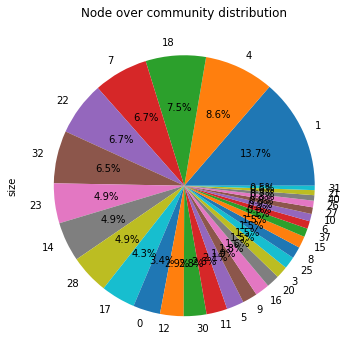

In [32]:
community_sizes = pd.Series(list(map(len, louvain)), name='size', index=range(len(louvain)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000491,CIT,0.006660,Li Zhang,0.000106,CIT,1.0,Jun Yun
1,0.000441,ISNN (2),0.004619,Bo Liu,0.000097,ISNN (2),1.0,ZhiWei Wang
2,0.000387,ISNN (1),0.003725,Wei Li,0.000088,FSKD,1.0,Jiachen Hou
3,0.000369,CSCWD,0.003667,Jun Ma,0.000088,ISNN (1),1.0,Halisson Brito
4,0.000363,FSKD,0.003028,Jing Yang,0.000081,International Conference on Internet Computing,1.0,A. Zuccotti
5,0.000316,International Conference on Internet Computing,0.002416,Gang Li,0.000080,CSCWD,1.0,Jiuchun Ren
6,0.000297,IAS,0.002296,Yu Chen,0.000071,IAS,1.0,Sen Zeng
7,0.000291,PDCAT,0.002237,Integrated PCA-FLD method for hyperspectral im...,0.000064,PDCAT,1.0,G. Faraco
8,0.000285,ICIC (2),0.002056,Bin Zhang,0.000062,IMECS,1.0,A. Marelli
9,0.000272,ICMLC,0.002030,Yong Wang,0.000062,ICMLC,1.0,Haili Liang


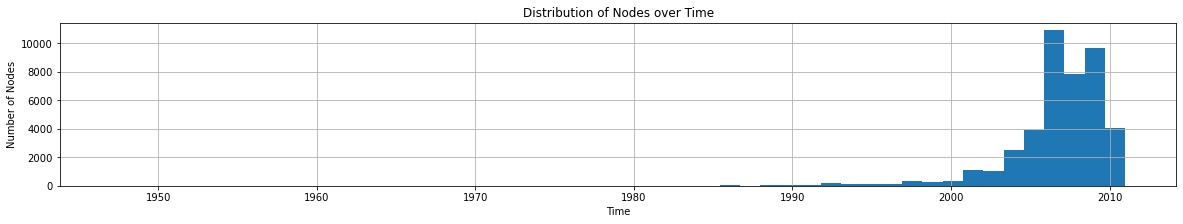

Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.006815,,0.218684,,0.003009,,1.0,Don L. Millard
1,0.002789,"Microwave Theory and Techniques, IEEE Transact...",0.036447,Proceedings of the 2009 IEEE International Sym...,0.000868,"Microwave Theory and Techniques, IEEE Transact...",1.0,Robert C. Block
2,0.002649,Electronics Letters,0.036447,Proceedings of the 2002 IEEE International Sym...,0.000722,"Antennas and Propagation, IEEE Transactions on",1.0,Junchang Ju
3,0.002292,"Antennas and Propagation, IEEE Transactions on",0.036447,Proceedings of the 2004 IEEE International Sym...,0.000708,"Automatic Control, IEEE Transactions on",1.0,M. Grazzini
4,0.002147,"Automatic Control, IEEE Transactions on",0.036447,Proceedings of the 2007 IEEE International Sym...,0.000626,Electronics Letters,1.0,Young-Sun Yun
5,0.001844,"Magnetics, IEEE Transactions on",0.036447,Proceedings of the 2006 IEEE International Sym...,0.000464,Encyclopedia of Database Systems,1.0,Guido Rindsfüser
6,0.001146,Encyclopedia of Database Systems,0.036447,Proceedings of the 2008 IEEE International Sym...,0.000388,"Magnetics, IEEE Transactions on",1.0,Karl R. Umstadter
7,0.000942,"Acoustics, Speech and Signal Processing, IEEE ...",0.005669,"Microwave Theory and Techniques, IEEE Transact...",0.000300,"Acoustics, Speech and Signal Processing, IEEE ...",1.0,P. Fuster
8,0.000798,KI,0.005513,Electronics Letters,0.000249,KI,1.0,John E. Collins
9,0.000742,Jr.,0.005347,"Magnetics, IEEE Transactions on",0.000232,Encyclopedia of GIS,1.0,M. Alduraibi


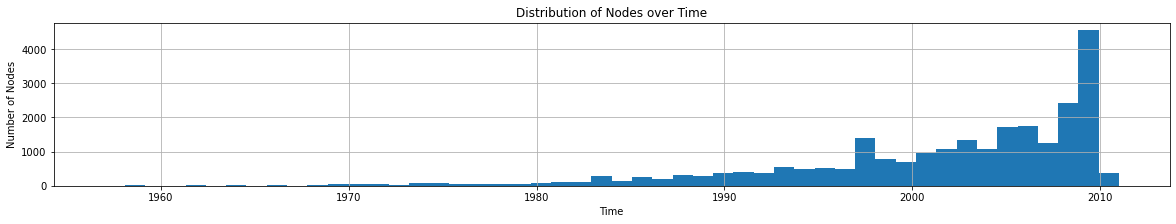

Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000155,IEEE Transactions on Reliability,0.000225,IEEE Transactions on Reliability,0.000044,IEEE Transactions on Reliability,1.000000,Dhruv M. Desai
1,0.000037,"Reliability and Maintainability Symposium, 198...",0.000091,Proceedings 15th Brazilian Symposium on Comput...,0.000013,"Reliability and Maintainability Symposium, 198...",1.000000,William Gavin Holland
2,0.000033,"Computer Graphics and Image Processing, 2002. ...",0.000091,"Computer Graphics and Image Processing, 2002. ...",0.000008,"Computer Graphics and Image Processing, 2002. ...",1.000000,James E. Hughes
3,0.000017,"Delicate Balance: Technics, Culture and Conseq...",0.000088,1984 Proceedings Annual Reliability and Mainta...,0.000007,"Delicate Balance: Technics, Culture and Conseq...",1.000000,Jason Aaron Matteson
4,0.000011,BladeCenter chassis management.,0.000088,"Reliability and Maintainability Symposium, 198...",0.000005,BladeCenter chassis management.,1.000000,Martin J. Crippen
5,0.000011,BladeCenter networking.,0.000071,Erratum.,0.000004,"BladeCenter processor blades, I/O expansion ad...",0.333333,Jose Julio Des Diz
6,0.000010,"BladeCenter processor blades, I/O expansion ad...",0.000038,Internet Architecture Supporting Sensor Networ...,0.000003,Gregory Levitin,0.333333,David W. Cosby
7,0.000010,Nong Ye,0.000036,Ternary State Circular Sequential k-out-of-n C...,0.000003,"BladeCenter packaging, power, and cooling.",0.333333,An extended model for optimal burn-in procedures.
8,0.000010,Way Kuo,0.000036,Generalized Access Structure Congestion System.,0.000003,Way Kuo,0.277778,BladeCenter thermal diagnostics.
9,0.000010,Gregory Levitin,0.000036,Circular sequential k-out-of-n congestion system.,0.000002,BladeCenter systems management software.,0.275000,BladeCenter solutions.


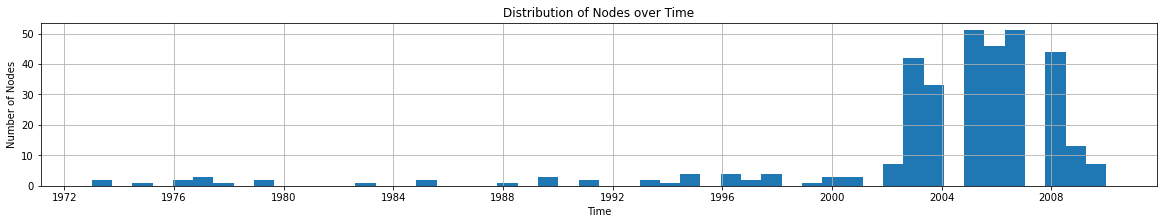

Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.002013,ISCAS,0.004477,Pre-Processing and Vector Quantization Based A...,0.000479,ISCAS,1.0,Akira Utagawa
1,0.000695,I. J. Bifurcation and Chaos,0.003551,ISCAS,0.000181,I. J. Bifurcation and Chaos,1.0,Joseph Micallef
2,0.000509,ISCAS (4),0.001230,I. J. Bifurcation and Chaos,0.000118,ISCAS (4),1.0,V. Makis
3,0.000492,ISCAS (1),0.000844,"Circuits and Systems, 2003. ISCAS '03. Proceed...",0.000117,ISCAS (3),1.0,Shuaiqi Wang
4,0.000474,ISCAS (3),0.000755,ISCAS (4),0.000116,ISCAS (1),1.0,Kiyoaki Yoshida
5,0.000471,ISCAS (5),0.000729,ISCAS (5),0.000111,ISCAS (5),1.0,Suraiya Pervin
6,0.000428,"Circuits and Systems, 2003. ISCAS '03. Proceed...",0.000700,ISCAS (1),0.000103,"Circuits and Systems, 2003. ISCAS '03. Proceed...",1.0,Bob Schell
7,0.000422,ISCAS (2),0.000640,ISCAS (3),0.000099,ISCAS (2),1.0,Rafal Kapela
8,0.000305,CCECE,0.000627,Zhihua Wang,0.000084,Scholarpedia,1.0,Yasumasa Sujaku
9,0.000266,"Journal of Circuits, Systems, and Computers",0.000624,Fast center-line extraction for quantification...,0.000075,CCECE,1.0,Shinnosuke Hirata


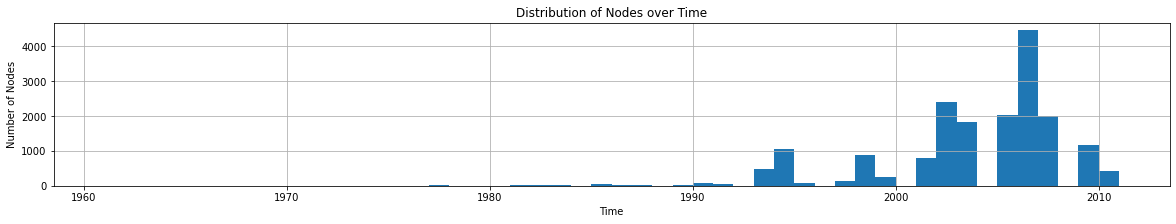

Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.002007,Pattern Recognition,0.826814,ISBI,0.000419,Pattern Recognition,1.0,Mehmet Turhal
1,0.001756,ICIP,0.053957,Lawrence H. Staib,0.000379,ICIP,1.0,Timothy C. Hoad
2,0.001391,Pattern Recognition Letters,0.024561,Marcel Jackowski,0.000333,NIPS,1.0,Xujun Peng
3,0.001352,NIPS,0.016729,Boundary Finding with Parametrically Deformabl...,0.000274,Neurocomputing,1.0,Peter A. Robinson
4,0.001307,Neurocomputing,0.010062,Reduced-Dimensionality Matching for 3-D Recons...,0.000269,IEEE Transactions on Image Processing,1.0,Chi-Shuan Liu
5,0.001277,IEEE Trans. Pattern Anal. Mach. Intell.,0.009831,Correcting the Geometry and Color of Digital I...,0.000254,ICME,1.0,Chia Yeow Yee
6,0.001245,IROS,0.008279,Improving the Reliability of Shape Comparison ...,0.000243,IROS,1.0,Gary Phipps
7,0.001225,ICME,0.007918,IEEE Trans. Pattern Anal. Mach. Intell.,0.000222,ICASSP,1.0,Boris Brimkov
8,0.001199,IEEE Transactions on Image Processing,0.007440,Instance-Based Generative Biological Shape Mod...,0.000218,Pattern Recognition Letters,1.0,Ehtesham Hassan
9,0.000964,ICASSP,0.007221,A Classifier Ensemble Based on Performance Lev...,0.000189,DAGM-Symposium,1.0,Julian R. Maclaren


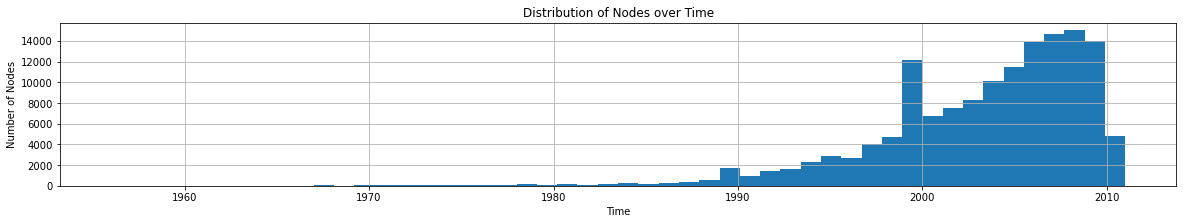

Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000858,Computers & Graphics,0.092124,Klaus Mueller,0.000244,Computers & Graphics,1.0,Sebastien Brault
1,0.000777,Computer-Aided Design,0.010569,Approximating Digital 3D Shapes by Rational Ga...,0.000190,Computer-Aided Design,1.0,David Coblentz
2,0.000644,Comput. Graph. Forum,0.008051,Empty Space Skipping and Occlusion Clipping fo...,0.000158,Comput. Graph. Forum,1.0,Dru Clark
3,0.000536,ACM Trans. Graph.,0.006805,An Effective Load Balancing Scheme for 3D Text...,0.000136,IV,1.0,David H. Rogers
4,0.000533,IV,0.006242,Implicit surface visualization of reconstructe...,0.000120,The Visual Computer,1.0,Colin Chibaya
5,0.000494,The Visual Computer,0.005626,Generating Sub-Resolution Detail in Images and...,0.000084,Computer Aided Geometric Design,1.0,Donna A. Dietz
6,0.000445,IEEE Visualization,0.004532,A practical evaluation of popular volume rende...,0.000082,IEEE Computer Graphics and Applications,1.0,David I. Ketcheson
7,0.000440,IEEE Trans. Vis. Comput. Graph.,0.004517,IEEE Trans. Vis. Comput. Graph.,0.000060,J. Comput. Sci. Technol.,1.0,Isabelle Cattiaux-Huillard
8,0.000438,Computer Aided Geometric Design,0.003682,Computers & Graphics,0.000055,IEEE Trans. Vis. Comput. Graph.,1.0,Chien-Fu Kuo
9,0.000418,SIGGRAPH,0.003598,IEEE Visualization,0.000051,ICCSA (3),1.0,Clifford M. Stein


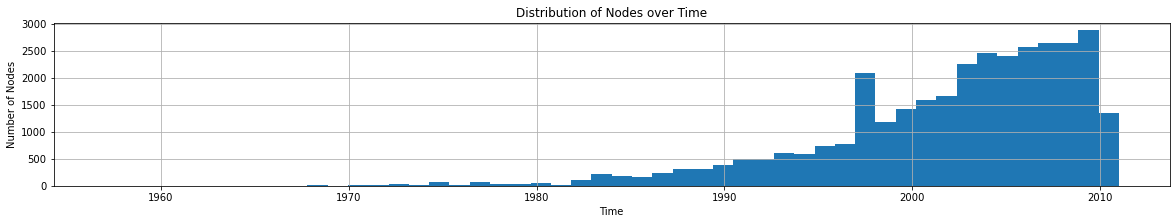

In [33]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(louvain))):
    # Show top k nodes
    community_node_names = names.loc[louvain[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )

    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No node timestamp data available')

### Label Propagation

In [34]:
label_prop = G_cc.community_label_propagation()
print(f'Modularity after Label Propagation: {G_cc.modularity(label_prop)}')
print(f'Number of communities: {len(label_prop)}')

Modularity after Label Propagation: 0.5925496797205394
Number of communities: 82890


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

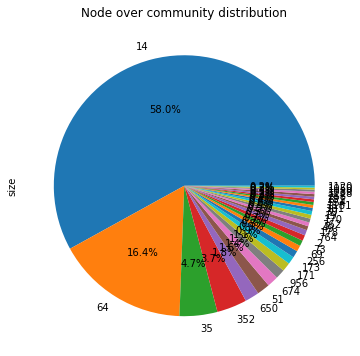

In [35]:
community_sizes = pd.Series(list(map(len, label_prop)), name='size', index=range(len(label_prop)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,2.241510e-06,一种面向语义Web的组合服务演化方法研究,0.000002,一种面向语义Web的组合服务演化方法研究,1.497702e-06,一种面向语义Web的组合服务演化方法研究,0.0,一种面向语义Web的组合服务演化方法研究
1,3.735850e-07,Aihua Bao,0.000000,Aihua Bao,1.089623e-07,Aihua Bao,NaN,Aihua Bao
2,3.735850e-07,Zhen Wang,0.000000,Zhen Wang,1.089623e-07,Zhen Wang,NaN,Zhen Wang
3,3.735850e-07,Xiaoxuan Wang,0.000000,Xiaoxuan Wang,1.089623e-07,Xiaoxuan Wang,NaN,Xiaoxuan Wang
4,3.735850e-07,Jiajia Miao,0.000000,Jiajia Miao,1.089623e-07,Jiajia Miao,NaN,Jiajia Miao


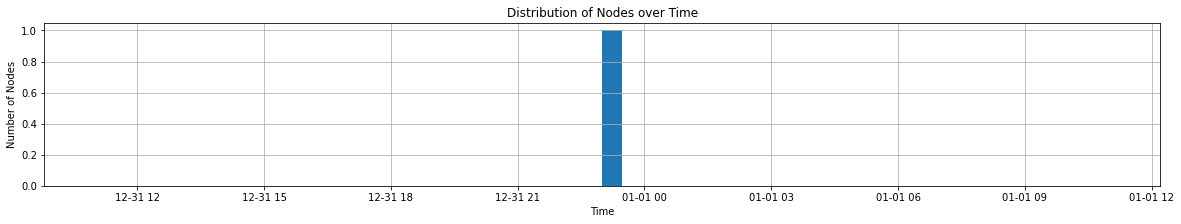

Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000689,"Nuclear Science, IEEE Transactions on",0.002939,"Nuclear Science, IEEE Transactions on",0.000120,"Nuclear Science, IEEE Transactions on",0.0,C.D.
1,0.000024,Radiation and Its Effects on Components and Sy...,0.000179,Image properties of list-mode likelihood recon...,0.000004,Radiation and Its Effects on Components and Sy...,0.0,Using linear time-invariant system theory to e...
2,0.000012,M. Singh,0.000176,Optimization of PET system design for lesion d...,0.000003,Design and performance of beam test electronic...,0.0,Spatial texture analysis: a comparative study
3,0.000010,S. Buchner,0.000118,Fourth European Conference on Radiation and It...,0.000003,M. Singh,0.0,2nd- and 4th-order &Sigma;&Delta; modulators f...
4,0.000010,H.S. Kim,0.000118,1989 IEEE Annual Nuclear and Space Radiation E...,0.000002,Performance and simulation of CdZnTe strip det...,0.0,Operating characteristics of radiation-hardene...
5,0.000010,Design and performance of beam test electronic...,0.000118,NMIS Author Index,0.000002,The use of content addressable memories in the...,0.0,Parameterization of Pb X-ray contamination in ...
6,0.000009,R.L. Pease,0.000118,Reviewers for this issue,0.000002,Gas proportional scintillation counters for th...,0.0,Incomplete-data CT image reconstructions in in...
7,0.000009,P.W. Marshall,0.000118,The cathode read-out of the DELPHI hadron calo...,0.000002,Updated measurements from CREAM and CREDO and ...,0.0,The role of model based control in robotics
8,0.000008,B.M.W. Tsui,0.000118,1997 IEEE Nuclear and Space Radiation Effects ...,0.000002,Observation and analysis of single event effec...,0.0,A new generation of SPECT and PET systems base...
9,0.000008,E.J. Hoffman,0.000118,1996 Medical Imaging Conference (MIC),0.000002,p-type silicon drift detectors: first results,0.0,On the validity of hypothesis testing for feas...


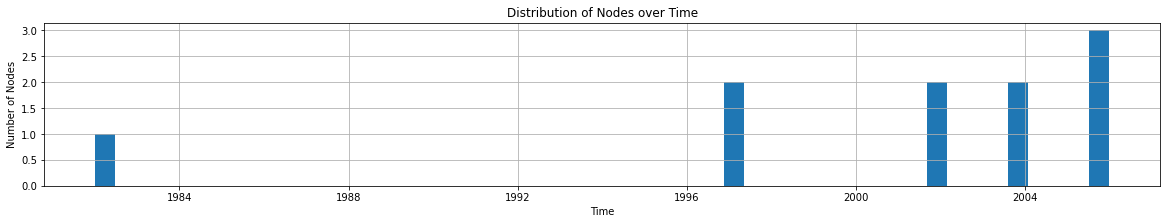

Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.002789,"Microwave Theory and Techniques, IEEE Transact...",0.005669,"Microwave Theory and Techniques, IEEE Transact...",0.000868,"Microwave Theory and Techniques, IEEE Transact...",0.066667,Yu-Wen Chang
1,0.000106,"Microwave and Guided Wave Letters, IEEE",0.000194,"Microwave and Guided Wave Letters, IEEE",0.000024,"Microwave and Guided Wave Letters, IEEE",0.000000,K.R.
2,0.000073,"Microwave Symposium Digest, GMTT International",0.000100,"Microwave Symposium Digest, GMTT International",0.000024,"Microwave Symposium Digest, GMTT International",0.000000,A New Configuration Providing Negative Resista...
3,0.000061,"Microwave Symposium Digest, 1974 S-MTT Interna...",0.000080,"Microwave Symposium Digest, 1974 S-MTT Interna...",0.000020,"Microwave Symposium Digest, 1974 S-MTT Interna...",0.000000,An Experimental Evaluation of Adaptive RADAR
4,0.000028,G.I. Haddad,0.000056,1997 Reviewers List,0.000008,"G-MTT International Symposium Digest, 1966",0.000000,Session 4 -- Microwave Theory
5,0.000027,J.W. Bandler,0.000026,"G-MTT International Symposium Digest, 1966",0.000007,PGMTT National Symposium Digest,0.000000,Determination of Semiconductor Junction Device...
6,0.000024,L. Young,0.000026,Computer-aided measurement of Q-factor with ap...,0.000007,J.R. Wait,0.000000,Application of Dual-Gate GaAs FET to Microwave...
7,0.000023,J. Helszajn,0.000025,PGMTT National Symposium Digest,0.000006,L. Young,0.000000,Symmetrical 2N-Port Directional Couplers
8,0.000022,"G-MTT International Symposium Digest, 1966",0.000021,Assessment of random and systematic errors in ...,0.000006,J. Helszajn,0.000000,Pulse Broadening in Multimode Optical Fibers w...
9,0.000022,E.G. Cristal,0.000014,"G-MTT Symposium Digest, 1965",0.000006,E.G. Cristal,0.000000,"Computer-Aided Design of Highly Linear, High-P..."


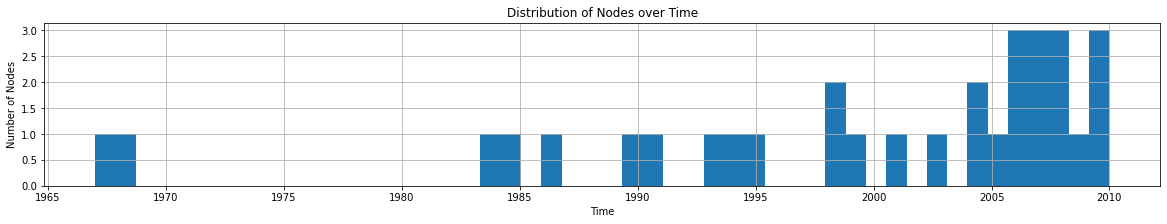

Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000216,"Aerospace and Electronic Systems, IEEE Transac...",3.974084e-04,"Aerospace and Electronic Systems, IEEE Transac...",0.000065,"Aerospace and Electronic Systems, IEEE Transac...",0.166667,Q. Yuan
1,0.000007,K. Gerlach,7.955640e-05,M. Barry Carlton award for 2006,0.000002,K. Gerlach,0.000000,F.F.
2,0.000005,J.A. Ritcey,7.955640e-05,Correction to data in January 1997 editorial,0.000001,N. Levanon,0.000000,Mixed graphic architecture for radar displays
3,0.000004,Y.T. Chan,5.354961e-05,Finite-dimensional filters with nonlinear drif...,0.000001,IMM/MHT solution to radar benchmark tracking p...,0.000000,Optimization of biased proportional navigation...
4,0.000004,N. Levanon,1.867926e-06,Target prescreening based on a quadratic gamma...,0.000001,J.A. Ritcey,0.000000,The early history of pulse compression radar-t...
5,0.000004,L. Hong,1.494341e-06,IMM/MHT solution to radar benchmark tracking p...,0.000001,S.K. Rao,0.000000,Control of nearly singular decoupling systems ...
6,0.000003,E.L. Titlebaum,1.143251e-06,Underwater acoustic communication by passive-p...,0.000001,N.M. Blachman,0.000000,Time-frequency hop codes based upon extended q...
7,0.000003,In-Joong Ha,1.120756e-06,A probabilistic nearest neighbor filter algori...,0.000001,R.M. Nelms,0.000000,Phase and logarithm of amplitude of a signal p...
8,0.000003,R.M. Nelms,9.764425e-07,The role of hardware in-loop motion simulation...,0.000001,Y.T. Chan,0.000000,A note on efficient SS/TDMA assignment algorithms
9,0.000003,W.D. Blair,9.339632e-07,A track filter for reentry objects with uncert...,0.000001,L. Hong,0.000000,Determination of required SNR values [radar de...


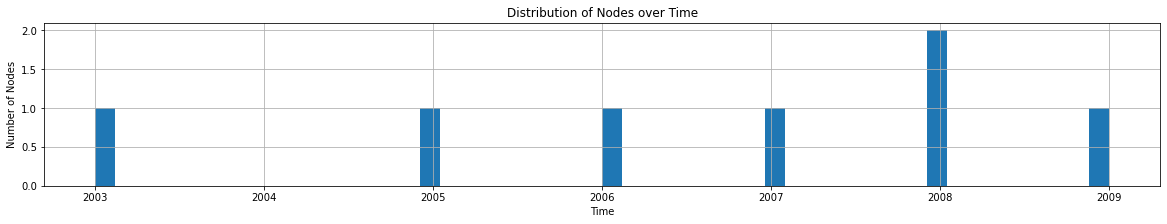

Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,2.615095e-06,Nonlinear system input structure identificatio...,6.147290e-07,Using fuzzy partitions to create fuzzy systems...,6.069891e-07,Nonlinear system input structure identificatio...,0.0,G.A.
1,2.241510e-06,Using fuzzy partitions to create fuzzy systems...,2.857704e-07,Nonlinear system input structure identificatio...,5.634167e-07,Using fuzzy partitions to create fuzzy systems...,0.0,Cunningham
2,1.494340e-06,G.A.,0.000000e+00,G.A.,2.631994e-07,G.A.,0.0,S.V. Coggeshall
3,1.120755e-06,Yinghua Lin,0.000000e+00,Cunningham,2.178356e-07,Yinghua Lin,0.0,Yinghua Lin
4,7.471700e-07,Cunningham,0.000000e+00,S.V. Coggeshall,1.543261e-07,Cunningham,0.0,Using fuzzy partitions to create fuzzy systems...
5,7.471700e-07,S.V. Coggeshall,0.000000e+00,Yinghua Lin,1.543261e-07,S.V. Coggeshall,0.0,Nonlinear system input structure identificatio...


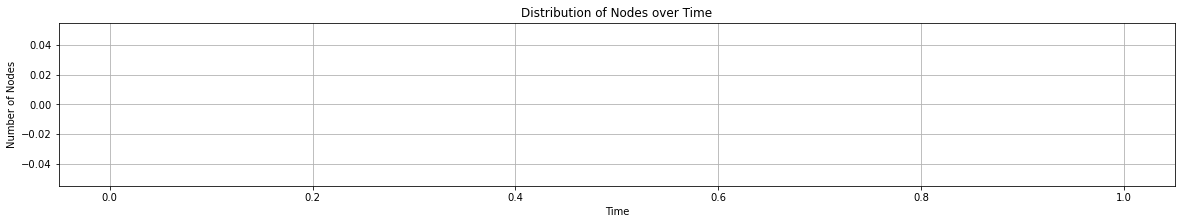

Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,2.615095e-06,US e-government authentication framework and p...,0.000002,US e-government authentication framework and p...,1.432914e-06,US e-government authentication framework and p...,0.0,US e-government authentication framework and p...
1,3.735850e-07,G.H.,0.000000,G.H.,1.014016e-07,G.H.,NaN,G.H.
2,3.735850e-07,D.S. Weitzel,0.000000,D.S. Weitzel,1.014016e-07,D.S. Weitzel,NaN,D.S. Weitzel
3,3.735850e-07,D.R. Copeland,0.000000,D.R. Copeland,1.014016e-07,D.R. Copeland,NaN,D.R. Copeland
4,3.735850e-07,Datesman,0.000000,Datesman,1.014016e-07,Datesman,NaN,Datesman


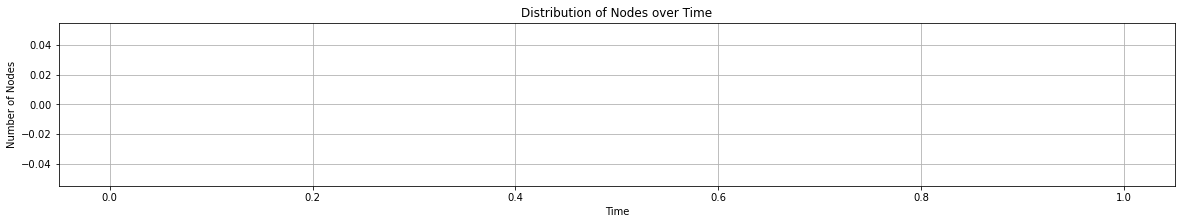

In [36]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(label_prop))):
    # Show top k nodes
    community_node_names = names.loc[label_prop[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )


    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No timestamp data available')